# 5. Capstone Project: Machine Learning Models I

***

![headerall](./images/headers/header_all.jpg)

##  Goals

### Project:
In this work, we will first analyze where and when traffic congestion is highest and lowest in New York State. We will then build different machine learning models capable of predicting cab travel times in and around New York City using only variables that can be easily obtained from a smartphone app or a website. We will then compare their performance and explore the possibility of using additional variables such as weather forecasts and holidays to improve the predictive performance of the models.

### Section:
In this section, we will use the knowledge gained during the exploratory data analysis to perform the final feature transformation. Next, we will create and compare the performance of several machine learning models, namely: linear regressions, a support vector machine regressor, a random forest regressor and a gradient boosted decision tree. The feature space and hyperparameters will be optimised for each model to obtain the best possible performance.

## Data
### External Datasets:
- Weather Forecast: The 2018 NYC weather forecast was collected from the [National Weather Service Forecast Office](https://w2.weather.gov/climate/index.php?wfo=okx) website. Daily measurements were taken from January to December 2018 in Central Park. These measures are given in imperial units and include daily minimum and maximum temperatures, precipitations, snowfall, and snow depth.

- Holidays: The 2018 NYC holidays list was collected from the [Office Holiday](https://www.officeholidays.com/countries/usa/new-york/2021) website. The dataset contains the name, date, and type of holidays for New York.

- Taxi Zones: The NYC Taxi Zones dataset was collected from the [NYC Open Data](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc) website. It contains the pickup and drop-off zones (Location IDs) for the Yellow, Green, and FHV Trip Records. The taxi zones are based on the NYC Department of City Planning’s Neighborhood.

### Primary Datasets:

- Taxi Trips: The 2018 NYC Taxi Trip dataset was collected from the [Google Big Query](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tlc-trips?project=jovial-monument-300209&folder=&organizationId=) platform. The dataset contains more than 100'000'000 Yellow Taxi Trip records for 2018 and contains an extensive amount of variables including the pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

***
## Table of Content:
    1. Data Preparation
        1.1 External Datasets
            1.1.1 Weather Forecast Dataset
            1.1.2 Holidays Dataset
            1.1.3 Taxi Zones Dataset
        1.2 Primary Dataset
            1.2.1 Taxi Trips Dataset
            1.2.2 Taxi Trips Subset
    2. Exploratory Data Analysis
        2.1 Primary Dataset
            2.1.1 Temporal Analysis
            2.1.2 Spatio-Temporal Analysis
        2.2 External Datasets
            2.2.1 Temporal Analysis of Weather Data
            2.2.2 Temporal Analysis of Holidays Data
        2.3 Combined Dataset
            2.3.1 Overall Features Correlation
    3. Machine Learning Models
        3.1 Data Preparation
        3.2 Baselines
        3.3 Model Training
            3.3.1 Linear Regression
            3.3.2 Support Vector Machine
            3.3.3 Random Forest
            3.3.4 Gradient Boosted Decision Tree
        3.4 Final Models Comparison
    5. Conclusions

***
## Python Libraries and Magic Commands Import

In [1]:
# Import python core libraries
import itertools

# Import data processing libraris gpd
import pandas as pd
import geopandas as gpd
import numpy as np

# Import Visualization librairies
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py
import scipy.stats as stats

# Import machine learning libraries
from sklearn.base import clone
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE 

In [2]:
# Set up magic commands
%matplotlib inline
%config Completer.use_jedi = False

***

## Data Import

In [3]:
# Import the train dataset
train_df = pd.read_pickle(r'data/processed/train.pickle')

# Get the independant variables from the train dataset
X_tr = train_df.drop("trip_duration", axis=1)

# Get the dependant variable from the train dataset
y_tr = train_df["trip_duration"]

print('X_tr:', X_tr.shape)
print('y_tr:', y_tr.shape, y_tr.dtype)

X_tr: (824654, 33)
y_tr: (824654,) float64


In [4]:
# Import the test dataset
test_df = pd.read_pickle(r'data/processed/test.pickle')

# Get the independant variables from the test dataset
X_te = test_df.drop("trip_duration", axis=1)

# Get the dependant variable from the test dataset
y_te = test_df["trip_duration"]

print('X_te:', X_te.shape)
print('y_te:', y_te.shape, y_te.dtype)

X_te: (206156, 33)
y_te: (206156,) float64


***
## Functions Import

In [5]:
# Define a function that transform column headers to titles
def to_title(data, sep='_'):
    return [s.replace(sep, ' ').title() for s in data]

In [6]:
# Define a function that display scatter plots of selected numerical columns
def plot_scatter(data, columns, colnames, variable, ncols=1, nrows=1, color="C0"):

    varname = variable.replace("_", " ").title()

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols * 5, nrows * 5)
    )

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        sns.scatterplot(x=col, y=variable, data=data, ax=ax, s=10, color=color)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_ylim(0)
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_ylabel(varname, fontsize=14)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

In [7]:
# Define a function that display scatter plots of selected numerical columns
def plot_histplot(data, columns, colnames, ncols=1, nrows=1, color="C0"):

    # Create a figure with n columns and rows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols * 5, nrows * 5)
    )

    # Flatten axes for 2D figures
    if ncols > 1 or nrows > 1:
        axes = axes.ravel()

    # Generate the plots
    for ax, col, colname in zip(axes, columns, colnames):
        sns.histplot(
            x=col, bins=20, data=data, ax=ax, color=color, edgecolor="white", alpha=0.7
        )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.tick_params(labelsize=14)
        ax.set_xlabel(colname, fontsize=14)
        ax.set_ylabel("Count", fontsize=14)
        ax.set_title(colname, fontsize=16)
        ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Display the figure
    plt.show()

In [8]:
def diagnostic_plots(data, variable, transform=None):

    if transform:
        data = data.copy()
        data[variable] = data[variable].apply(transform)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    data[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(data[variable], dist="norm", plot=plt)

    plt.show()

In [9]:
def transform_opt(data, transformations, showBest=True):

    output = pd.DataFrame({"None": data.skew()})

    for tr in transformations:
        data_copy = data.copy()
        output[tr.__name__] = data_copy.apply(tr).skew()

    if filter:
        return output.loc[np.abs(output["None"]) > 1]

    return output

***
# 3. Machine Learning Models
## 3.1 Machine Learning Models: Data Preparation

## Goals:
Perform the final steps of data preparation, including feature transformation, before starting the training of the different machine learning models.

## Code:

In [10]:
# Get id column names from the train dataset
id_cols = [c for c in train_df.columns if "id" in c]

# Remove ID features in the train dataset
train_df.drop(id_cols, axis=1, inplace=True)

# Remove ID features in the test dataset
test_df.drop(id_cols, axis=1, inplace=True)

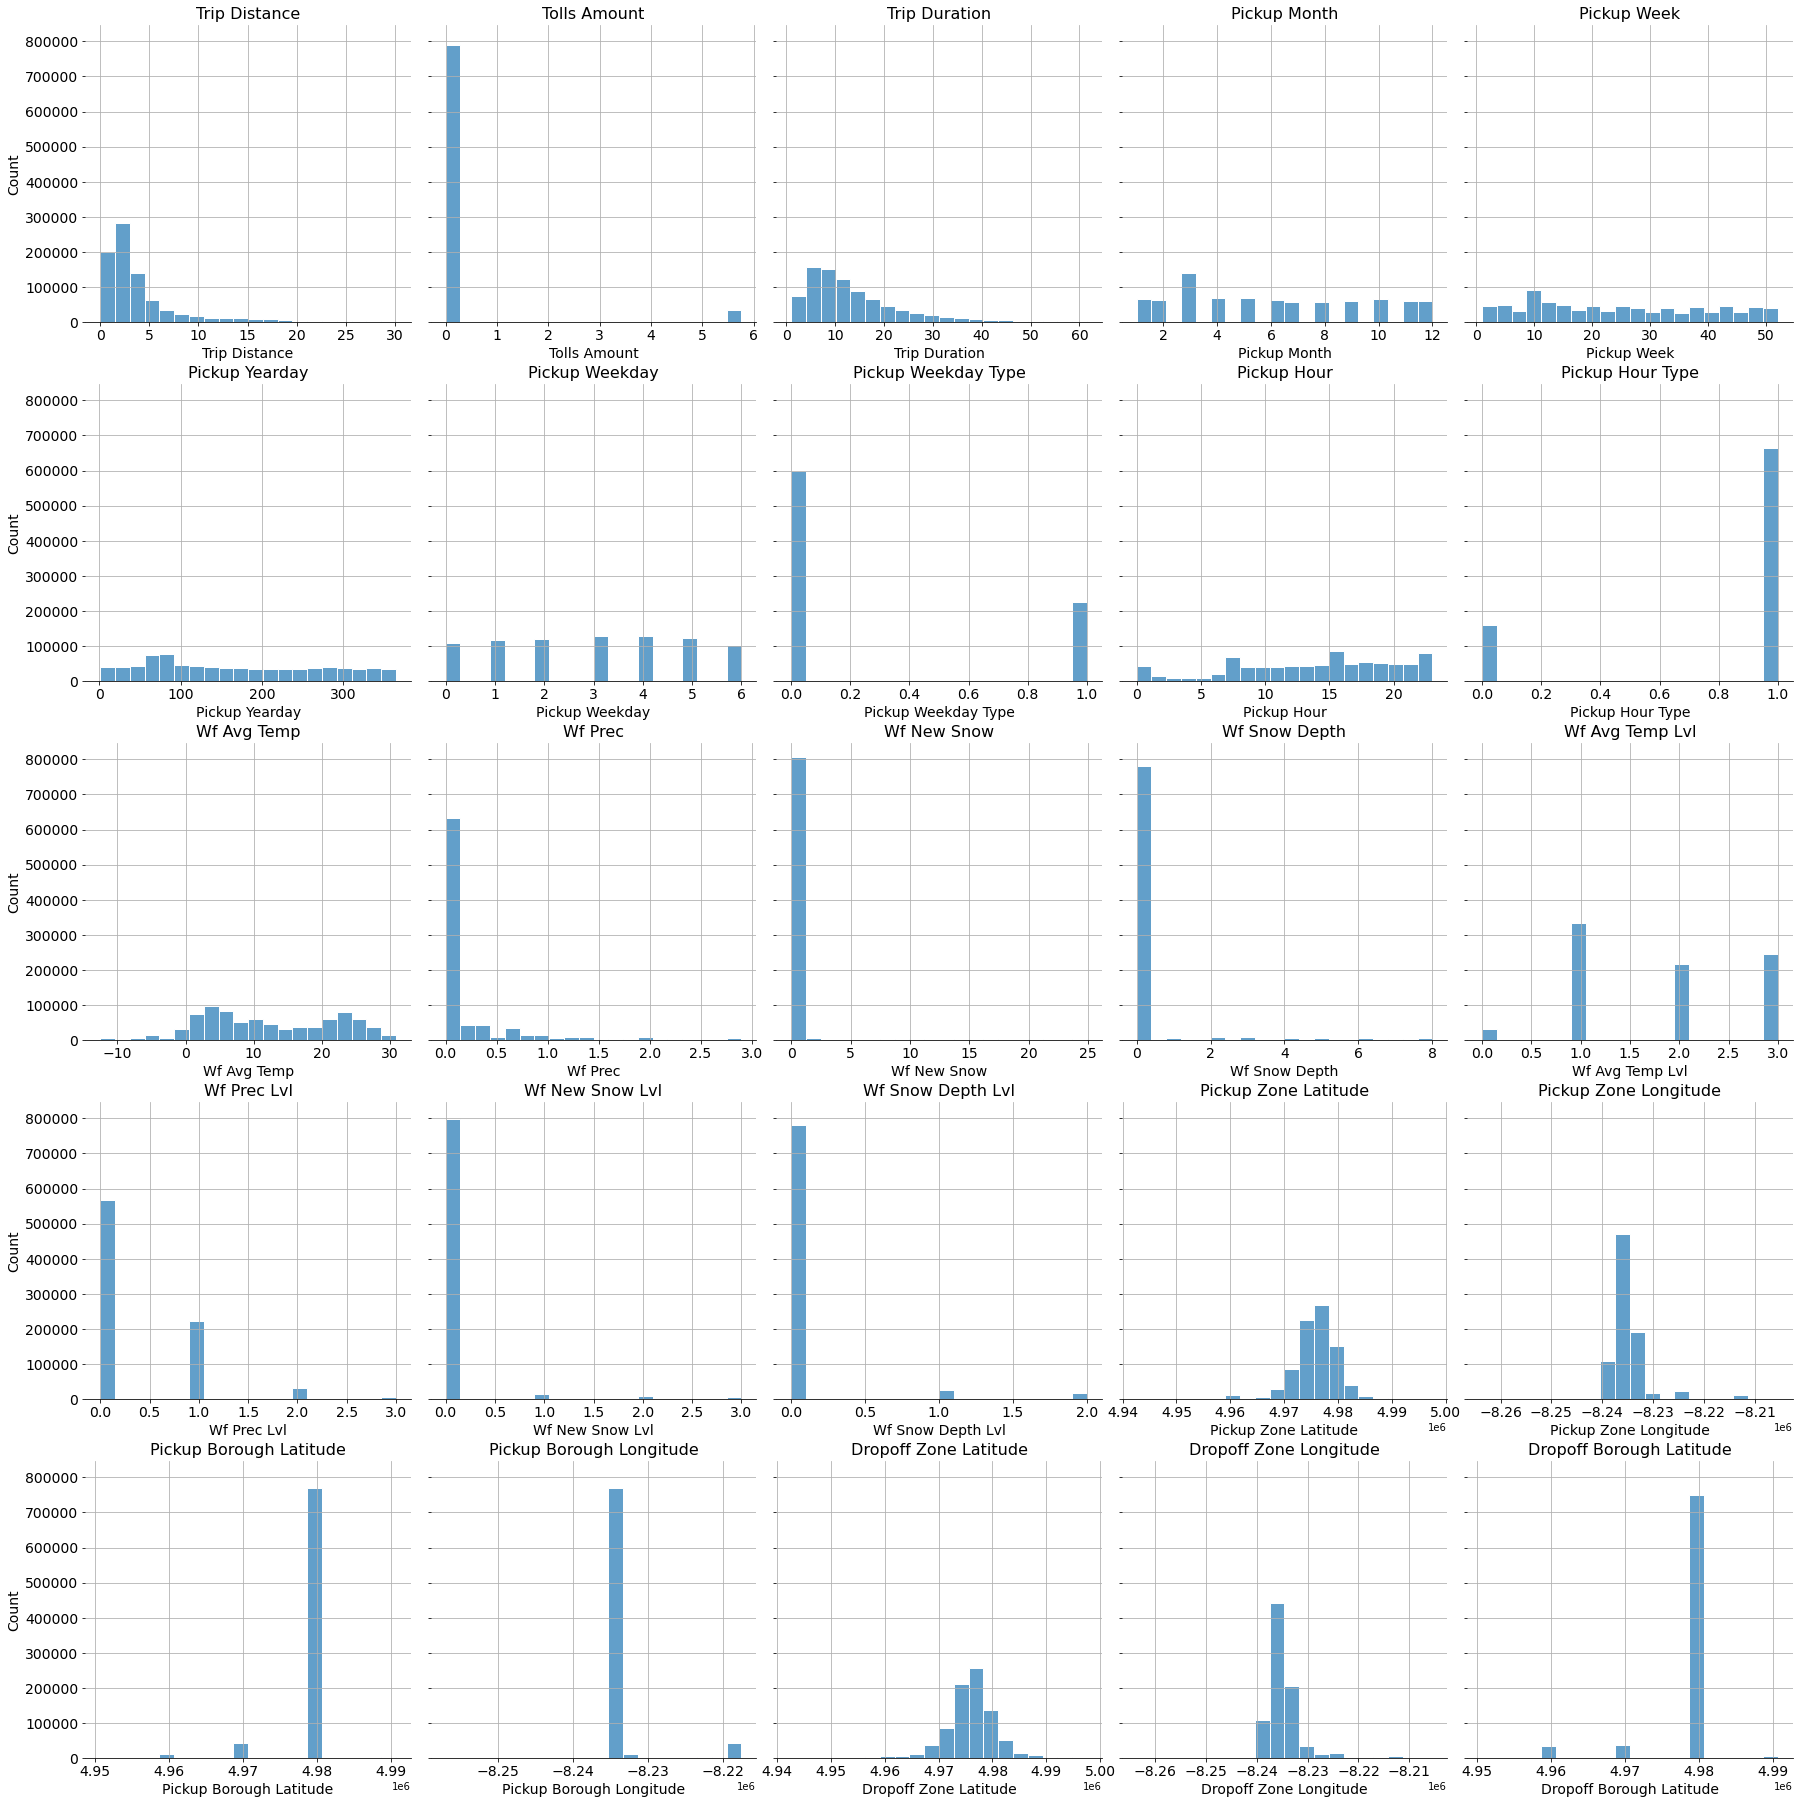

In [11]:
# Get the name of numerical columns
train_num_cols = train_df.columns

# Display scatterplot of numerical columns
plot_histplot(
    train_df,
    train_num_cols,
    to_title(train_num_cols),
    ncols=5,
    nrows=5,
)

**Note:** As we saw earlier in the explanatory analysis, several characteristics have a skewed distribution. Mathematical transformations can be applied to give the data a normal distribution. The objective now is to find out which transformation is best suited to which variable.

In [12]:
# Define the transformation to perform on the features
transformations = [np.log10, np.log1p, np.square, np.sqrt, np.exp]

# Perform various feature transformations and collect the restults in a data frame
transform_opt(train_df, transformations, showBest=False)

C:\Users\tstricker\Anaconda3\envs\ml\lib\site-packages\pandas\core\nanops.py:1205: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted ** 2


,None,log10,log1p,square,sqrt,exp
trip_distance,2.776230,0.389387,0.960956,4.902220,1.619644,18.512662
tolls_amount,4.638982,NaN,4.626269,4.652049,4.626119,4.658063
trip_duration,1.603420,-0.195451,0.001339,3.544290,0.711595,45.089997
pickup_weekday_type,1.020380,NaN,1.020380,1.020380,1.020380,1.020380
pickup_hour_type,-1.553683,NaN,-1.553683,-1.553683,-1.553683,-1.553683
wf_prec,3.425993,NaN,2.430261,7.274151,1.728736,8.411640
wf_new_snow,9.223834,NaN,7.355789,12.044836,7.543670,29.562308
wf_snow_depth,5.638233,NaN,4.611249,7.718923,4.590881,12.250835
wf_prec_lvl,1.592009,NaN,1.065455,4.542668,0.943447,5.781420
wf_new_snow_lvl,6.912921,NaN,6.039903,9.178275,5.789853,10.113432


**Notes:** Values close to 0 mean that the distribution after transformation is close to a Gaussian. The Log10 and sqrt transformations seem to give the best results overall.

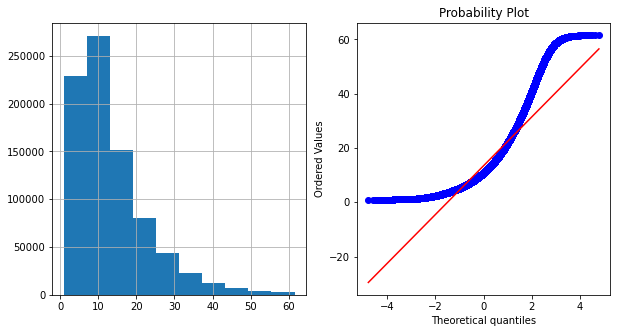

In [13]:
# Generates and display a probability plot to check whether the data follows a normal distribution.
diagnostic_plots(train_df, "trip_duration")

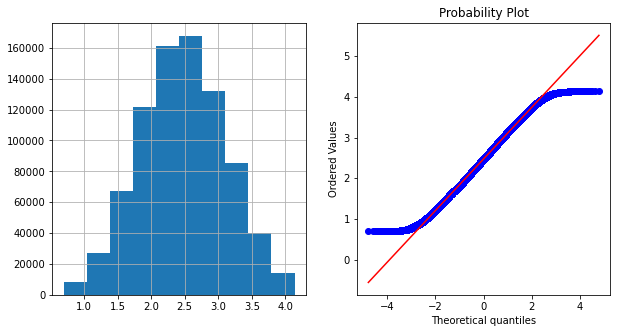

In [14]:
# Generates and display a probability plot to check whether the data follows a normal distribution after feature transformation.
diagnostic_plots(train_df, "trip_duration", transform=np.log1p)

**Notes:**

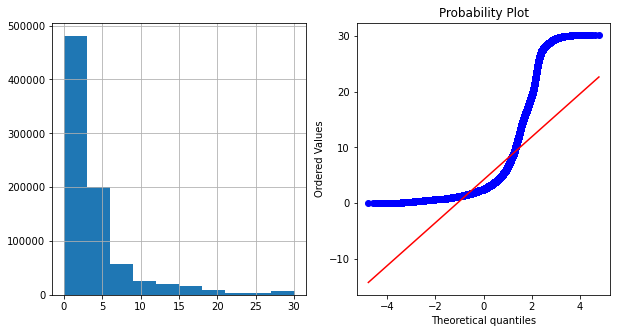

In [15]:
# Generates and display a probability plot to check whether the data follows a normal distribution.
diagnostic_plots(train_df, "trip_distance")

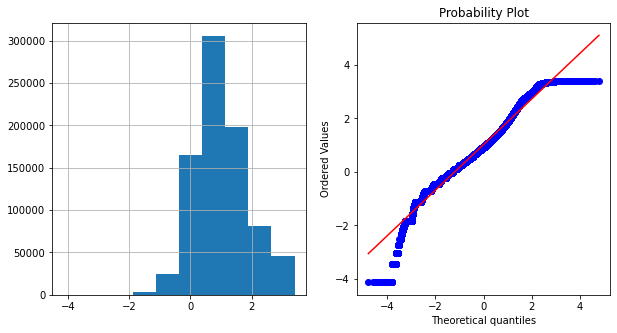

In [16]:
# Generates and display a probability plot to check whether the data follows a normal distribution after feature transformation.
diagnostic_plots(train_df, "trip_distance", transform=np.log)

**Notes:** Log and Log1p transformed the right-skewed distributions of travel time and distance into fairly good Gaussian curves.

## 3.1 Machine Learning Models: Baselines

## Goals:
Compute the mean absolute error (MSE), and mean absolute error (MAE) baselines. These two baselines will then be used to benchmarkthe performance of the different models.

## Code:

In [17]:
# Compute the MAE of the median baseline
mse_mean_baseline = MSE(y_te, np.full(len(y_te), np.mean(y_tr)))

print("The MSE of the mean baseline is: {:.1f}".format(mse_mean_baseline))

The MSE of the mean baseline is: 93.6


In [18]:
# Compute the MAE of the median baseline
mae_median_baseline = MAE(y_te, np.full(len(y_te), np.median(y_tr)))

print("The MAE of the median baseline is: {:.1f}".format(mae_median_baseline))

The MAE of the median baseline is: 5.0


***
## Export Files

In [19]:
# Create a new data frame containing the MSE and MAE of the model
sr_results = pd.DataFrame({
    'model':['bs'],
    'mse': [mse_mean_baseline],
    'mae': [mae_median_baseline],
})

# Save the results in the project folder
sr_results.to_csv('results/bs_model.csv', index=False)